In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from datetime import datetime

#prepare log return for Pfizer
pfizer = yf.Ticker('TSLA')
old = pfizer.history(start="2012-01-01",  end= "2022-01-01")
old.head()
    

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2012-01-03 00:00:00-05:00,1.929333,1.966667,1.843333,1.872000,13921500,0,0.0
2012-01-04 00:00:00-05:00,1.880667,1.911333,1.833333,1.847333,9451500,0,0.0
2012-01-05 00:00:00-05:00,1.850667,1.862000,1.790000,1.808000,15082500,0,0.0
2012-01-06 00:00:00-05:00,1.813333,1.852667,1.760667,1.794000,14794500,0,0.0
2012-01-09 00:00:00-05:00,1.800000,1.832667,1.741333,1.816667,13455000,0,0.0


In [2]:
old = old.reset_index()
old['Date'] = pd.to_datetime(old['Date']).dt.tz_convert(None)
old.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-01-03 05:00:00,1.929333,1.966667,1.843333,1.872000,13921500,0,0.0
1,2012-01-04 05:00:00,1.880667,1.911333,1.833333,1.847333,9451500,0,0.0
2,2012-01-05 05:00:00,1.850667,1.862000,1.790000,1.808000,15082500,0,0.0
3,2012-01-06 05:00:00,1.813333,1.852667,1.760667,1.794000,14794500,0,0.0
4,2012-01-09 05:00:00,1.800000,1.832667,1.741333,1.816667,13455000,0,0.0


In [3]:
old['log_return'] = np.log(old['Close']/old['Close'].shift(1)).dropna()
old = old.tail(old.shape[0] -1)
old

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,log_return
1,2012-01-04 05:00:00,1.880667,1.911333,1.833333,1.847333,9451500,0,0.0,-0.013264
2,2012-01-05 05:00:00,1.850667,1.862000,1.790000,1.808000,15082500,0,0.0,-0.021522
3,2012-01-06 05:00:00,1.813333,1.852667,1.760667,1.794000,14794500,0,0.0,-0.007773
4,2012-01-09 05:00:00,1.800000,1.832667,1.741333,1.816667,13455000,0,0.0,0.012556
5,2012-01-10 05:00:00,1.829333,1.850667,1.816667,1.841333,10077000,0,0.0,0.013486
...,...,...,...,...,...,...,...,...,...
2512,2021-12-27 05:00:00,357.890015,372.333344,356.906677,364.646667,71145900,0,0.0,0.024935
2513,2021-12-28 05:00:00,369.829987,373.000000,359.473328,362.823334,60324000,0,0.0,-0.005013
2514,2021-12-29 05:00:00,366.213318,368.000000,354.713318,362.063324,56154000,0,0.0,-0.002097
2515,2021-12-30 05:00:00,353.776672,365.183319,351.049988,356.779999,47040900,0,0.0,-0.014700


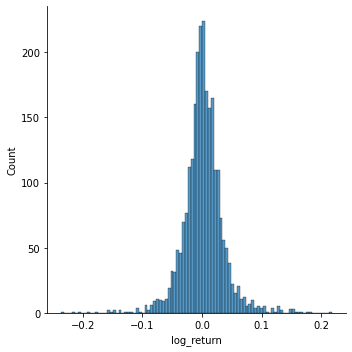

In [4]:
#the real distribution of log returns
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(old['log_return'])
plt.show()

In [5]:
# -*- coding: utf-8 -*-
# import dataiku as dk
#from finance.option_pricing import *

from tqdm import tqdm
import torch 
from torch import nn 
import torch.optim as optim
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow import keras
from tensorflow.keras import Input, initializers, Model
from tensorflow.keras.layers import Dense, Activation, LeakyReLU, Dropout
######################
##  INITIALIZATION  ##
######################

np.random.seed(2027)
random_dim = 100
dim_out = 50
batch_size = 32
epochs = 150

''' input data here...
input_dataset_name = "sp500_live_prepared"
ticker = dk.dku_flow_variables["DKU_DST_ticker"]
path = os.path.join(dk.Folder("PbrBLsHH").get_path(), ticker)
if not os.path.exists(path):
	os.mkdir(path)
'''

#######################
#### GAN functions ####
#######################

def get_optimizer():
    return(Adam(learning_rate = 0.0002, beta_1 = 0.5))

def get_fgenerator(optimizer, random_dim, dim_out):
    noise = Input(shape = (random_dim,))
    x = Dense(256,kernel_initializer = initializers.RandomNormal(stddev = 0.02))(noise)
    relu = LeakyReLU(0.2)(x)
    
    x = Dense(512)(relu)
    relu = LeakyReLU(0.2)(x)
    
    x = Dense(1024)(relu)
    relu = LeakyReLU(0.2)(x)
    
    generated_time_series = Dense(dim_out, activation = 'tanh')(relu)
    
    generator = Model(noise, generated_time_series)
    generator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    return(generator)

def get_fdiscriminator(optimizer, dim_out):
    fakes_or_not = Input(shape = (dim_out,))
    
    x = Dense(1024,kernel_initializer = initializers.RandomNormal(stddev = 0.02))(fakes_or_not)
    relu = LeakyReLU(0.2)(x)
    drop = Dropout(0.3)(relu)
    
    x = Dense(512)(drop)
    relu = LeakyReLU(0.2)(x)
    drop = Dropout(0.3)(relu)
    
    x = Dense(256)(drop)
    relu = LeakyReLU(0.2)(x)
    drop = Dropout(0.3)(relu)
    
    # The discriminator prediction is a flag, whether or not this time series is fake or not
    pred = Dense(1, activation = "sigmoid")(drop)
    discriminator = Model(fakes_or_not, pred)
    discriminator.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    return(discriminator)

def get_gan_network(discriminator, generator, optimizer, random_dim):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    
    discriminator.trainable = False
    gan_input = Input(shape = (random_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs = gan_input, outputs = gan_output)
    gan.compile(loss = 'binary_crossentropy', optimizer = optimizer)
    return(gan)

def prepare_gan(optimizer, random_dim, dim_out):
    generator = get_fgenerator(optimizer, random_dim, dim_out)
    discriminator = get_fdiscriminator(optimizer, dim_out)  
    gan = get_gan_network(discriminator, generator, optimizer, random_dim)
    return(generator, discriminator, gan)
'''
def save_generator(generator, path):
    generator_json = generator.to_json()
    with open(path + "/generator.json", "w") as f:
        f.write(generator_json)
    generator.save_weights(path + "/generator.h5")
'''
###################
##  MAIN ENGINE  ##
###################

# Get optimizer
adam = get_optimizer()

# get training set
df = old
x_train = np.array([old.log_return.values[i-50:i] for i in range(50,df.shape[0])])
batch_count = x_train.shape[0] // batch_size

# Prepare GAN
generator, discriminator, gan = prepare_gan(adam, random_dim, dim_out)

# Training Loop
for e in tqdm(range(1, epochs + 1)):
    for _ in range(batch_count):
        # Get a random set of input noise and time_series
        noise = np.random.normal(0, 1, size=[batch_size, random_dim])
        time_series_batch = x_train[np.random.randint(0, x_train.shape[0], size = batch_size)]

        # Generate fake time_series - concat with real time_series
        generated_time_series = generator.predict(noise)
        X = np.concatenate([time_series_batch, generated_time_series])

        # Labels for generated and real data - One-sided label smoothing
        y_dis = np.zeros(2 * batch_size)
        y_dis[:batch_size] = 0.9

        # Train discriminator
        discriminator.trainable = True
        discriminator.train_on_batch(X, y_dis)

        # Train generator
        noise = np.random.normal(0, 1, size = [batch_size, random_dim])
        y_gen = np.ones(batch_size)
        discriminator.trainable = False
        gan.train_on_batch(noise, y_gen)

# Save model
# save = save_generator(generator, path)

  0%|                                                                                                                                           | 0/150 [00:00<?, ?it/s]

1/1 [==============================] - 0s 15ms/step


  1%|▊                                                                                                                                  | 1/150 [00:06<16:35,  6.68s/it]

1/1 [==============================] - 0s 14ms/step


  1%|█▋                                                                                                                                 | 2/150 [00:12<15:08,  6.14s/it]

1/1 [==============================] - 0s 15ms/step


  2%|██▌                                                                                                                                | 3/150 [00:18<14:27,  5.90s/it]

1/1 [==============================] - 0s 16ms/step


  3%|███▍                                                                                                                               | 4/150 [00:23<14:05,  5.79s/it]

1/1 [==============================] - 0s 15ms/step


  3%|████▎                                                                                                                              | 5/150 [00:29<13:55,  5.76s/it]

1/1 [==============================] - 0s 15ms/step


  4%|█████▏                                                                                                                             | 6/150 [00:35<13:48,  5.75s/it]

1/1 [==============================] - 0s 15ms/step


  5%|██████                                                                                                                             | 7/150 [00:40<13:37,  5.71s/it]

1/1 [==============================] - 0s 15ms/step


  5%|██████▉                                                                                                                            | 8/150 [00:46<13:27,  5.69s/it]

1/1 [==============================] - 0s 15ms/step


  6%|███████▊                                                                                                                           | 9/150 [00:52<13:29,  5.74s/it]

1/1 [==============================] - 0s 15ms/step


  7%|████████▋                                                                                                                         | 10/150 [00:58<13:27,  5.77s/it]

1/1 [==============================] - 0s 16ms/step


  7%|█████████▌                                                                                                                        | 11/150 [01:03<13:26,  5.80s/it]

1/1 [==============================] - 0s 15ms/step


  8%|██████████▍                                                                                                                       | 12/150 [01:09<13:11,  5.73s/it]

1/1 [==============================] - 0s 16ms/step


  9%|███████████▎                                                                                                                      | 13/150 [01:15<12:54,  5.66s/it]

1/1 [==============================] - 0s 15ms/step


  9%|████████████▏                                                                                                                     | 14/150 [01:20<12:44,  5.62s/it]

1/1 [==============================] - 0s 15ms/step


 10%|█████████████                                                                                                                     | 15/150 [01:26<12:36,  5.60s/it]

1/1 [==============================] - 0s 15ms/step


 11%|█████████████▊                                                                                                                    | 16/150 [01:31<12:25,  5.57s/it]

1/1 [==============================] - 0s 15ms/step


 11%|██████████████▋                                                                                                                   | 17/150 [01:37<12:19,  5.56s/it]

1/1 [==============================] - 0s 17ms/step


 12%|███████████████▌                                                                                                                  | 18/150 [01:42<12:18,  5.59s/it]

1/1 [==============================] - 0s 15ms/step


 13%|████████████████▍                                                                                                                 | 19/150 [01:48<12:26,  5.70s/it]

1/1 [==============================] - 0s 16ms/step


 13%|█████████████████▎                                                                                                                | 20/150 [01:54<12:24,  5.73s/it]

1/1 [==============================] - 0s 15ms/step


 14%|██████████████████▏                                                                                                               | 21/150 [02:00<12:19,  5.73s/it]

1/1 [==============================] - 0s 15ms/step


 15%|███████████████████                                                                                                               | 22/150 [02:06<12:16,  5.75s/it]

1/1 [==============================] - 0s 17ms/step


 15%|███████████████████▉                                                                                                              | 23/150 [02:12<12:20,  5.83s/it]

1/1 [==============================] - 0s 15ms/step


 16%|████████████████████▊                                                                                                             | 24/150 [02:18<12:25,  5.91s/it]

1/1 [==============================] - 0s 17ms/step


 17%|█████████████████████▋                                                                                                            | 25/150 [02:24<12:29,  6.00s/it]

1/1 [==============================] - 0s 15ms/step


 17%|██████████████████████▌                                                                                                           | 26/150 [02:30<12:18,  5.96s/it]

1/1 [==============================] - 0s 15ms/step


 18%|███████████████████████▍                                                                                                          | 27/150 [02:36<12:20,  6.02s/it]

1/1 [==============================] - 0s 17ms/step


 19%|████████████████████████▎                                                                                                         | 28/150 [02:42<12:28,  6.13s/it]

1/1 [==============================] - 0s 16ms/step


 19%|█████████████████████████▏                                                                                                        | 29/150 [02:49<12:24,  6.15s/it]

1/1 [==============================] - 0s 20ms/step


 20%|██████████████████████████                                                                                                        | 30/150 [02:55<12:18,  6.16s/it]

1/1 [==============================] - 0s 20ms/step


 21%|██████████████████████████▊                                                                                                       | 31/150 [03:01<12:16,  6.19s/it]

1/1 [==============================] - 0s 15ms/step


 21%|███████████████████████████▋                                                                                                      | 32/150 [03:07<12:21,  6.28s/it]

1/1 [==============================] - 0s 15ms/step


 22%|████████████████████████████▌                                                                                                     | 33/150 [03:14<12:27,  6.39s/it]

1/1 [==============================] - 0s 22ms/step


 23%|█████████████████████████████▍                                                                                                    | 34/150 [03:21<12:24,  6.41s/it]

1/1 [==============================] - 0s 21ms/step


 23%|██████████████████████████████▎                                                                                                   | 35/150 [03:27<12:21,  6.44s/it]

1/1 [==============================] - 0s 18ms/step


 24%|███████████████████████████████▏                                                                                                  | 36/150 [03:33<12:12,  6.42s/it]

1/1 [==============================] - 0s 15ms/step


 25%|████████████████████████████████                                                                                                  | 37/150 [03:40<12:05,  6.42s/it]

1/1 [==============================] - 0s 15ms/step


 25%|████████████████████████████████▉                                                                                                 | 38/150 [03:46<11:46,  6.31s/it]

1/1 [==============================] - 0s 21ms/step


 26%|█████████████████████████████████▊                                                                                                | 39/150 [03:52<11:29,  6.21s/it]

1/1 [==============================] - 0s 21ms/step


 27%|██████████████████████████████████▋                                                                                               | 40/150 [03:58<11:23,  6.21s/it]

1/1 [==============================] - 0s 16ms/step


 27%|███████████████████████████████████▌                                                                                              | 41/150 [04:04<11:15,  6.20s/it]

1/1 [==============================] - 0s 15ms/step


 28%|████████████████████████████████████▍                                                                                             | 42/150 [04:10<11:09,  6.20s/it]

1/1 [==============================] - 0s 17ms/step


 29%|█████████████████████████████████████▎                                                                                            | 43/150 [04:17<11:09,  6.26s/it]

1/1 [==============================] - 0s 16ms/step


 29%|██████████████████████████████████████▏                                                                                           | 44/150 [04:23<10:52,  6.16s/it]

1/1 [==============================] - 0s 18ms/step


 30%|███████████████████████████████████████                                                                                           | 45/150 [04:29<10:42,  6.11s/it]

1/1 [==============================] - 0s 18ms/step


 31%|███████████████████████████████████████▊                                                                                          | 46/150 [04:35<10:30,  6.06s/it]

1/1 [==============================] - 0s 15ms/step


 31%|████████████████████████████████████████▋                                                                                         | 47/150 [04:41<10:28,  6.10s/it]

1/1 [==============================] - 0s 15ms/step


 32%|█████████████████████████████████████████▌                                                                                        | 48/150 [04:47<10:12,  6.01s/it]

1/1 [==============================] - 0s 15ms/step


 33%|██████████████████████████████████████████▍                                                                                       | 49/150 [04:53<10:05,  6.00s/it]

1/1 [==============================] - 0s 15ms/step


 33%|███████████████████████████████████████████▎                                                                                      | 50/150 [04:59<10:02,  6.02s/it]

1/1 [==============================] - 0s 18ms/step


 34%|████████████████████████████████████████████▏                                                                                     | 51/150 [05:05<09:59,  6.05s/it]

1/1 [==============================] - 0s 14ms/step


 35%|█████████████████████████████████████████████                                                                                     | 52/150 [05:11<09:51,  6.04s/it]

1/1 [==============================] - 0s 16ms/step


 35%|█████████████████████████████████████████████▉                                                                                    | 53/150 [05:17<09:56,  6.15s/it]

1/1 [==============================] - 0s 16ms/step


 36%|██████████████████████████████████████████████▊                                                                                   | 54/150 [05:25<10:31,  6.58s/it]

1/1 [==============================] - 0s 15ms/step


 37%|███████████████████████████████████████████████▋                                                                                  | 55/150 [05:31<10:16,  6.49s/it]

1/1 [==============================] - 0s 17ms/step


 37%|████████████████████████████████████████████████▌                                                                                 | 56/150 [05:38<10:06,  6.45s/it]

1/1 [==============================] - 0s 16ms/step


 38%|█████████████████████████████████████████████████▍                                                                                | 57/150 [05:44<09:57,  6.42s/it]

1/1 [==============================] - 0s 17ms/step


 39%|██████████████████████████████████████████████████▎                                                                               | 58/150 [05:50<09:44,  6.35s/it]

1/1 [==============================] - 0s 16ms/step


 39%|███████████████████████████████████████████████████▏                                                                              | 59/150 [05:56<09:34,  6.31s/it]

1/1 [==============================] - 0s 22ms/step


 40%|████████████████████████████████████████████████████                                                                              | 60/150 [06:03<09:28,  6.32s/it]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████████████████████████████████████████▊                                                                             | 61/150 [06:09<09:17,  6.26s/it]

1/1 [==============================] - 0s 15ms/step


 41%|█████████████████████████████████████████████████████▋                                                                            | 62/150 [06:15<09:12,  6.28s/it]

1/1 [==============================] - 0s 18ms/step


 42%|██████████████████████████████████████████████████████▌                                                                           | 63/150 [06:21<09:07,  6.29s/it]

1/1 [==============================] - 0s 15ms/step


 43%|███████████████████████████████████████████████████████▍                                                                          | 64/150 [06:28<09:00,  6.28s/it]

1/1 [==============================] - 0s 15ms/step


 43%|████████████████████████████████████████████████████████▎                                                                         | 65/150 [06:34<08:56,  6.31s/it]

1/1 [==============================] - 0s 15ms/step


 44%|█████████████████████████████████████████████████████████▏                                                                        | 66/150 [06:40<08:48,  6.29s/it]

1/1 [==============================] - 0s 17ms/step


 45%|██████████████████████████████████████████████████████████                                                                        | 67/150 [06:47<08:41,  6.29s/it]

1/1 [==============================] - 0s 15ms/step


 45%|██████████████████████████████████████████████████████████▉                                                                       | 68/150 [06:53<08:40,  6.35s/it]

1/1 [==============================] - 0s 16ms/step


 46%|███████████████████████████████████████████████████████████▊                                                                      | 69/150 [06:59<08:32,  6.33s/it]

1/1 [==============================] - 0s 17ms/step


 47%|████████████████████████████████████████████████████████████▋                                                                     | 70/150 [07:06<08:31,  6.40s/it]

1/1 [==============================] - 0s 17ms/step


 47%|█████████████████████████████████████████████████████████████▌                                                                    | 71/150 [07:12<08:26,  6.42s/it]

1/1 [==============================] - 0s 16ms/step


 48%|██████████████████████████████████████████████████████████████▍                                                                   | 72/150 [07:19<08:22,  6.44s/it]

1/1 [==============================] - 0s 17ms/step


 49%|███████████████████████████████████████████████████████████████▎                                                                  | 73/150 [07:25<08:15,  6.43s/it]

1/1 [==============================] - 0s 17ms/step


 49%|████████████████████████████████████████████████████████████████▏                                                                 | 74/150 [07:32<08:11,  6.47s/it]

1/1 [==============================] - 0s 17ms/step


 50%|█████████████████████████████████████████████████████████████████                                                                 | 75/150 [07:39<08:10,  6.54s/it]

1/1 [==============================] - 0s 18ms/step


 51%|█████████████████████████████████████████████████████████████████▊                                                                | 76/150 [07:45<07:59,  6.48s/it]

1/1 [==============================] - 0s 17ms/step


 51%|██████████████████████████████████████████████████████████████████▋                                                               | 77/150 [07:51<07:49,  6.44s/it]

1/1 [==============================] - 0s 16ms/step


 52%|███████████████████████████████████████████████████████████████████▌                                                              | 78/150 [07:58<07:43,  6.43s/it]

1/1 [==============================] - 0s 16ms/step


 53%|████████████████████████████████████████████████████████████████████▍                                                             | 79/150 [08:04<07:45,  6.56s/it]

1/1 [==============================] - 0s 18ms/step


 53%|█████████████████████████████████████████████████████████████████████▎                                                            | 80/150 [08:11<07:43,  6.63s/it]

1/1 [==============================] - 0s 16ms/step


 54%|██████████████████████████████████████████████████████████████████████▏                                                           | 81/150 [08:18<07:44,  6.73s/it]

1/1 [==============================] - 0s 19ms/step


 55%|███████████████████████████████████████████████████████████████████████                                                           | 82/150 [08:25<07:44,  6.83s/it]

1/1 [==============================] - 0s 15ms/step


 55%|███████████████████████████████████████████████████████████████████████▉                                                          | 83/150 [08:32<07:38,  6.85s/it]

1/1 [==============================] - 0s 17ms/step


 56%|████████████████████████████████████████████████████████████████████████▊                                                         | 84/150 [08:39<07:28,  6.80s/it]

1/1 [==============================] - 0s 18ms/step


 57%|█████████████████████████████████████████████████████████████████████████▋                                                        | 85/150 [08:46<07:32,  6.96s/it]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████████████████████████████████▌                                                       | 86/150 [08:53<07:22,  6.92s/it]

1/1 [==============================] - 0s 17ms/step


 58%|███████████████████████████████████████████████████████████████████████████▍                                                      | 87/150 [09:00<07:13,  6.89s/it]

1/1 [==============================] - 0s 17ms/step


 59%|████████████████████████████████████████████████████████████████████████████▎                                                     | 88/150 [09:07<07:11,  6.96s/it]

1/1 [==============================] - 0s 18ms/step


 59%|█████████████████████████████████████████████████████████████████████████████▏                                                    | 89/150 [09:14<07:07,  7.01s/it]

1/1 [==============================] - 0s 22ms/step


 60%|██████████████████████████████████████████████████████████████████████████████                                                    | 90/150 [09:21<07:00,  7.00s/it]

1/1 [==============================] - 0s 16ms/step


 61%|██████████████████████████████████████████████████████████████████████████████▊                                                   | 91/150 [09:28<06:54,  7.03s/it]

1/1 [==============================] - 0s 17ms/step


 61%|███████████████████████████████████████████████████████████████████████████████▋                                                  | 92/150 [09:35<06:43,  6.96s/it]

1/1 [==============================] - 0s 18ms/step


 62%|████████████████████████████████████████████████████████████████████████████████▌                                                 | 93/150 [09:42<06:38,  6.99s/it]

1/1 [==============================] - 0s 20ms/step


 63%|█████████████████████████████████████████████████████████████████████████████████▍                                                | 94/150 [09:49<06:35,  7.07s/it]

1/1 [==============================] - 0s 16ms/step


 63%|██████████████████████████████████████████████████████████████████████████████████▎                                               | 95/150 [09:56<06:26,  7.03s/it]

1/1 [==============================] - 0s 16ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████▏                                              | 96/150 [10:03<06:16,  6.97s/it]

1/1 [==============================] - 0s 16ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████                                              | 97/150 [10:10<06:09,  6.97s/it]

1/1 [==============================] - 0s 16ms/step


 65%|████████████████████████████████████████████████████████████████████████████████████▉                                             | 98/150 [10:17<06:02,  6.97s/it]

1/1 [==============================] - 0s 19ms/step


 66%|█████████████████████████████████████████████████████████████████████████████████████▊                                            | 99/150 [10:24<05:59,  7.05s/it]

1/1 [==============================] - 0s 17ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████                                           | 100/150 [10:32<06:02,  7.25s/it]

1/1 [==============================] - 0s 18ms/step


 67%|██████████████████████████████████████████████████████████████████████████████████████▊                                          | 101/150 [10:39<05:58,  7.32s/it]

1/1 [==============================] - 0s 17ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████▋                                         | 102/150 [10:47<05:54,  7.39s/it]

1/1 [==============================] - 0s 17ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████▌                                        | 103/150 [10:55<05:51,  7.47s/it]

1/1 [==============================] - 0s 17ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████▍                                       | 104/150 [11:03<05:50,  7.61s/it]

1/1 [==============================] - 0s 17ms/step


 70%|██████████████████████████████████████████████████████████████████████████████████████████▎                                      | 105/150 [11:10<05:44,  7.65s/it]

1/1 [==============================] - 0s 20ms/step


 71%|███████████████████████████████████████████████████████████████████████████████████████████▏                                     | 106/150 [11:18<05:38,  7.69s/it]

1/1 [==============================] - 0s 17ms/step


 71%|████████████████████████████████████████████████████████████████████████████████████████████                                     | 107/150 [11:26<05:31,  7.71s/it]

1/1 [==============================] - 0s 17ms/step


 72%|████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 108/150 [11:34<05:25,  7.74s/it]

1/1 [==============================] - 0s 17ms/step


 73%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 109/150 [11:42<05:18,  7.77s/it]

1/1 [==============================] - 0s 19ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 110/150 [11:50<05:14,  7.85s/it]

1/1 [==============================] - 0s 19ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 111/150 [11:58<05:15,  8.09s/it]

1/1 [==============================] - 0s 17ms/step


 75%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 112/150 [12:06<05:07,  8.10s/it]

1/1 [==============================] - 0s 17ms/step


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 113/150 [12:14<04:57,  8.05s/it]

1/1 [==============================] - 0s 16ms/step


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████                               | 114/150 [12:22<04:48,  8.01s/it]

1/1 [==============================] - 0s 17ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 115/150 [12:30<04:38,  7.95s/it]

1/1 [==============================] - 0s 18ms/step


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 116/150 [12:38<04:29,  7.93s/it]

1/1 [==============================] - 0s 17ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 117/150 [12:46<04:23,  7.97s/it]

1/1 [==============================] - 0s 18ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 118/150 [12:54<04:15,  7.99s/it]

1/1 [==============================] - 0s 19ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 119/150 [13:02<04:09,  8.05s/it]

1/1 [==============================] - 0s 19ms/step


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 120/150 [13:10<04:02,  8.07s/it]

1/1 [==============================] - 0s 21ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 121/150 [13:19<04:00,  8.31s/it]

1/1 [==============================] - 0s 19ms/step


 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 122/150 [13:28<03:59,  8.56s/it]

1/1 [==============================] - 0s 18ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 123/150 [13:37<03:51,  8.58s/it]

1/1 [==============================] - 0s 18ms/step


 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 124/150 [13:45<03:42,  8.55s/it]

1/1 [==============================] - 0s 20ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 125/150 [13:54<03:33,  8.52s/it]

1/1 [==============================] - 0s 18ms/step


 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 126/150 [14:02<03:24,  8.53s/it]

1/1 [==============================] - 0s 18ms/step


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 127/150 [14:11<03:18,  8.64s/it]

1/1 [==============================] - 0s 18ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 128/150 [14:21<03:13,  8.81s/it]

1/1 [==============================] - 0s 20ms/step


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 129/150 [14:30<03:06,  8.90s/it]

1/1 [==============================] - 0s 17ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 130/150 [14:39<03:03,  9.16s/it]

1/1 [==============================] - 0s 19ms/step


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 131/150 [14:48<02:52,  9.10s/it]

1/1 [==============================] - 0s 20ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 132/150 [14:57<02:41,  8.96s/it]

1/1 [==============================] - 0s 19ms/step


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 133/150 [15:06<02:30,  8.83s/it]

1/1 [==============================] - 0s 19ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 134/150 [15:15<02:21,  8.87s/it]

1/1 [==============================] - 0s 19ms/step


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 135/150 [15:24<02:14,  9.00s/it]

1/1 [==============================] - 0s 18ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 136/150 [15:33<02:05,  8.96s/it]

1/1 [==============================] - 0s 19ms/step


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 137/150 [15:41<01:55,  8.88s/it]

1/1 [==============================] - 0s 18ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 138/150 [15:50<01:46,  8.90s/it]

1/1 [==============================] - 0s 23ms/step


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 139/150 [16:00<01:38,  8.99s/it]

1/1 [==============================] - 0s 19ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 140/150 [16:09<01:30,  9.05s/it]

1/1 [==============================] - 0s 20ms/step


 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 141/150 [16:18<01:21,  9.09s/it]

1/1 [==============================] - 0s 20ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 142/150 [16:27<01:13,  9.24s/it]

1/1 [==============================] - 0s 19ms/step


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 143/150 [16:37<01:04,  9.21s/it]

1/1 [==============================] - 0s 20ms/step


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 144/150 [16:46<00:55,  9.30s/it]

1/1 [==============================] - 0s 19ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 145/150 [16:56<00:46,  9.39s/it]

1/1 [==============================] - 0s 21ms/step


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 146/150 [17:06<00:38,  9.55s/it]

1/1 [==============================] - 0s 19ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 147/150 [17:15<00:28,  9.48s/it]

1/1 [==============================] - 0s 20ms/step


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 148/150 [17:24<00:18,  9.41s/it]

1/1 [==============================] - 0s 19ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 149/150 [17:34<00:09,  9.38s/it]

1/1 [==============================] - 0s 19ms/step


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [17:43<00:00,  7.09s/it]


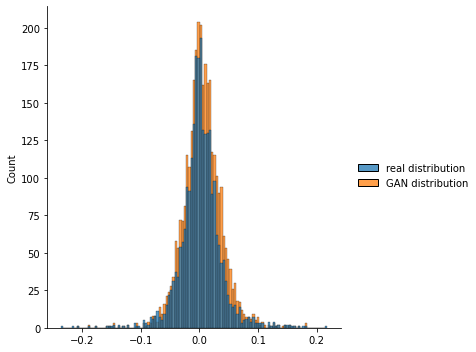

In [6]:
c = X.flatten()
sns.displot(data = {'real distribution': old['log_return'], 'GAN distribution': c})
plt.show()

In [7]:
y_dis

array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
       0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])

In [8]:
#GBM
scen_size = 10000
So = old.Close.values[0]
dt = 1  # day   # User input
T = 251 * 10
N = T / dt
t = np.arange(1, int(N) + 1)
mu = np.mean(old['log_return'])
sigma = np.std(old['log_return'])
b = {str(scen): np.random.normal(0, 1, int(N)) for scen in range(1, scen_size + 1)}
W = {str(scen): b[str(scen)].cumsum() for scen in range(1, scen_size + 1)}


# Calculating drift and diffusion components
drift = (mu - 0.5 * sigma ** 2) * t
diffusion = {str(scen): sigma * W[str(scen)] for scen in range(1, scen_size + 1)}

# Making the predictions
S = np.array([So * np.exp(drift + diffusion[str(scen)]) for scen in range(1, scen_size + 1)])
S = np.hstack((np.array([[So] for scen in range(scen_size)]), S))  # add So to the beginning series
S_max = [S[:, i].max() for i in range(0, int(N))]
S_min = [S[:, i].min() for i in range(0, int(N))]
S_pred = .5 * np.array(S_max) + .5 * np.array(S_min)
gbm_dataframe = pd.DataFrame({'gbm_prices':S_pred})
gbm_dataframe.head(-5)

,gbm_prices
0,1.847333
1,1.868529
2,1.850780
3,1.872033
4,1.889130
...,...
2500,18030.893325
2501,17980.920161
2502,17326.494631
2503,17615.521026


In [9]:
gbm_dataframe['log_return'] = np.log(gbm_dataframe['gbm_prices']/gbm_dataframe['gbm_prices'].shift(1)).dropna()
gbm_dataframe = gbm_dataframe.tail(old.shape[0] -1)
gbm_dataframe.head(-5)

,gbm_prices,log_return
0,1.847333,NaN
1,1.868529,0.011409
2,1.850780,-0.009545
3,1.872033,0.011418
4,1.889130,0.009091
...,...,...
2500,18030.893325,0.054250
2501,17980.920161,-0.002775
2502,17326.494631,-0.037074
2503,17615.521026,0.016544


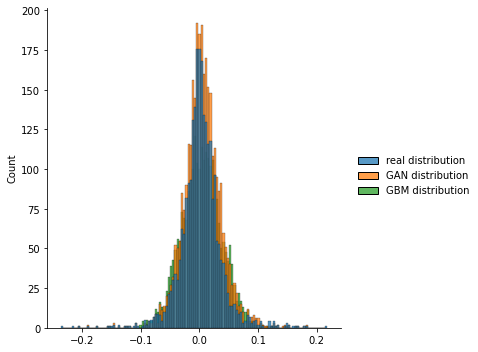

In [10]:
sns.displot(data = {'real distribution': old['log_return'], 'GAN distribution': c, 'GBM distribution' : gbm_dataframe['log_return']})

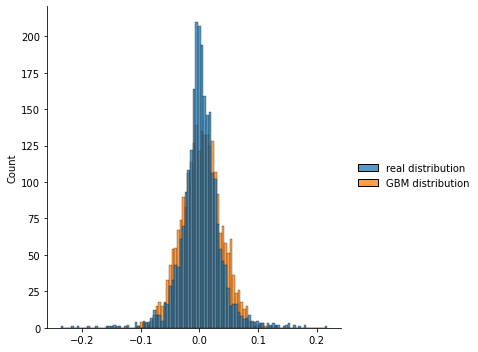

In [11]:
sns.displot(data = {'real distribution': old['log_return'], 'GBM distribution' : gbm_dataframe['log_return']})